K-Means

In [613]:
%load_ext google.cloud.bigquery
%matplotlib inline
from google.cloud import bigquery
client = bigquery.Client()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import cluster
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import random
from sklearn.cluster import KMeans
import matplotlib.cm as cm
%run silhouette_plotter.py
from mpl_toolkits.mplot3d import Axes3D

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [614]:
sql = '''
SELECT *  FROM `eth-tokens.alldata.clean_avg_with_balances_tokens_1MM`
'''

df = client.query(sql).to_dataframe()

In [615]:
#remove address (string) from analysis
data = df.iloc[:,1:]

In [616]:
#number of PCA features is full reconstruction, for now
num_features = data.shape[1]
num_clusters = 4

In [617]:
scale = StandardScaler()
pca =PCA(n_components=num_features)
cl = KMeans(num_clusters)
#build pipeline
pipe = Pipeline([('scale', scale ),
                 ('PCA', pca)])

results = pipe.fit_transform(data)

cl.fit(results)



KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

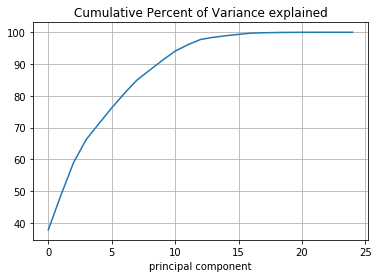

In [618]:
#percent of variance explained by each component

plt.plot(np.arange(pca.n_components_) ,np.cumsum(pca.explained_variance_ratio_)*100)
plt.grid(b=True)
plt.xlabel('principal component')
plt.title('Cumulative Percent of Variance explained')
plt.show()

Text(0.5,1,'Calinski Harabaz Scores')

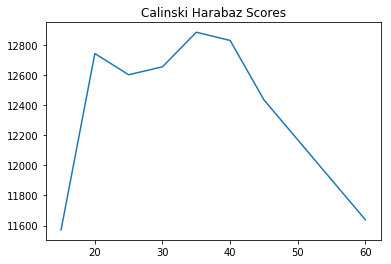

In [621]:
#scoring metric?
from sklearn.metrics import calinski_harabaz_score as ch_score
clusters = [15,20,25,30,35, 40,45, 60]
scores = []
inertias = []
for c in clusters:
    cl_n = KMeans(c).fit(results)
    score = ch_score(results, cl_n.labels_)
    scores.append(score)
    inertias.append(cl_n.inertia_)


plt.plot(clusters, scores)
plt.title('Calinski Harabaz Scores')

Text(0,0.5,'within cluster sum of squares')

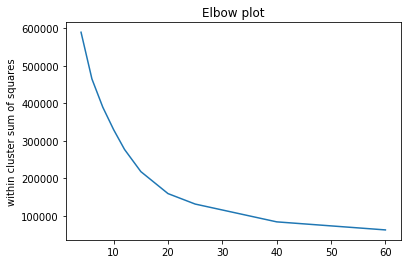

In [620]:
#elbow plot
plt.plot(clusters,inertias)
plt.title('Elbow plot')
plt.ylabel('within cluster sum of squares')

In [622]:
#optimal number of clusters is around 20
cl = KMeans(20)
cl.fit(results)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [623]:
#outlier removal


def remove_outliers(results, cl, threshold):
    '''
    returns subset of results, and associated labels as a tuple
    takes results and a fit KMeans cluster object'''
    
    new_labels = []
    new_results = []
    
    
    #code for deciding what clusters to keep
    for i, center in enumerate(cl.cluster_centers_):
        within_cluster_results = results[cl.labels_==i]
        centroid = cl.cluster_centers_[i]
        #calc std vectors
        stdev = np.std(within_cluster_results, axis=0)
       
        keep = np.linalg.norm((centroid - within_cluster_results), axis=1) < threshold*np.linalg.norm(stdev)
        new_results.append(within_cluster_results[keep])
        #add labels?
        new_labels.extend([i for j in range(len(within_cluster_results[keep]))])
    return np.vstack(new_results), np.array(new_labels)


In [624]:
thresholds = np.linspace(.3,3, 20)

test = [remove_outliers(results, cl,t) for t in thresholds]

scores= []
for (res, labels) in test:
    
    score = ch_score(res, labels)
    scores.append(score)

Text(0.5,1,'Calinski Harabaz Scores as std threshold changes')

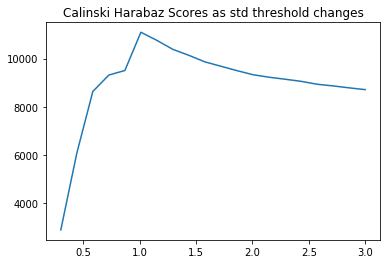

In [625]:
plt.plot(thresholds, scores)
plt.title('Calinski Harabaz Scores as std threshold changes')

In [626]:
#empirical best threshold 1 stdev
newresults, labels = remove_outliers(results, cl,1)

In [627]:
%run silhouette_plotter.py
X=results
range_n_clusters = [20]
if len(newresults) <20000:
    silhouette_plotter(X, range_n_clusters)

<Figure size 432x288 with 0 Axes>

In [628]:
import time
from sklearn.manifold import TSNE
n_sne = 7000

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(results)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 42527 samples in 0.053s...
[t-SNE] Computed neighbors for 42527 samples in 15.636s...
[t-SNE] Computed conditional probabilities for sample 1000 / 42527
[t-SNE] Computed conditional probabilities for sample 2000 / 42527
[t-SNE] Computed conditional probabilities for sample 3000 / 42527
[t-SNE] Computed conditional probabilities for sample 4000 / 42527
[t-SNE] Computed conditional probabilities for sample 5000 / 42527
[t-SNE] Computed conditional probabilities for sample 6000 / 42527
[t-SNE] Computed conditional probabilities for sample 7000 / 42527
[t-SNE] Computed conditional probabilities for sample 8000 / 42527
[t-SNE] Computed conditional probabilities for sample 9000 / 42527
[t-SNE] Computed conditional probabilities for sample 10000 / 42527
[t-SNE] Computed conditional probabilities for sample 11000 / 42527
[t-SNE] Computed conditional probabilities for sample 12000 / 42527
[t-SNE] Computed conditional probabilities for s

Text(0,0.5,'second principcal component')

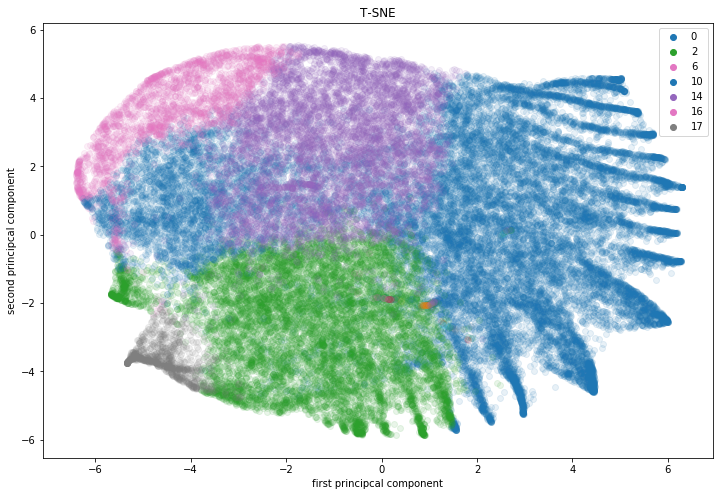

In [629]:
plt.figure(figsize=(12,8))
for c in np.unique(cl.labels_):
    mask = cl.labels_==c
    if np.sum(mask) <50:
        lbl = '_nolegend_'
    else:
        lbl = c
    plt.scatter(tsne_results[mask][:,0], tsne_results[mask][:,1], alpha=.1,label=lbl)
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.title('T-SNE')
plt.xlabel('first principcal component')
plt.ylabel('second principcal component')

In [630]:
#3d
time_start = time.time()
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(results)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 42527 samples in 0.054s...
[t-SNE] Computed neighbors for 42527 samples in 15.521s...
[t-SNE] Computed conditional probabilities for sample 1000 / 42527
[t-SNE] Computed conditional probabilities for sample 2000 / 42527
[t-SNE] Computed conditional probabilities for sample 3000 / 42527
[t-SNE] Computed conditional probabilities for sample 4000 / 42527
[t-SNE] Computed conditional probabilities for sample 5000 / 42527
[t-SNE] Computed conditional probabilities for sample 6000 / 42527
[t-SNE] Computed conditional probabilities for sample 7000 / 42527
[t-SNE] Computed conditional probabilities for sample 8000 / 42527
[t-SNE] Computed conditional probabilities for sample 9000 / 42527
[t-SNE] Computed conditional probabilities for sample 10000 / 42527
[t-SNE] Computed conditional probabilities for sample 11000 / 42527
[t-SNE] Computed conditional probabilities for sample 12000 / 42527
[t-SNE] Computed conditional probabilities for s

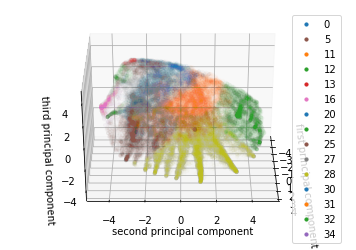

In [656]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c in np.unique(cl.labels_):
    mask = cl.labels_==c
    if np.sum(mask) <50:
        lbl = '_nolegend_'
    else:
        lbl = c
    ax.scatter(tsne_results[mask][:,0], tsne_results[mask][:,1], tsne_results[mask][:,2], s=10, alpha=.01,label=lbl)
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
ax.set_xlabel('first principal component')
ax.set_ylabel('second principal component')
ax.set_zlabel('third principal component')
ax.view_init(elev=30, azim=0)
plt.show()


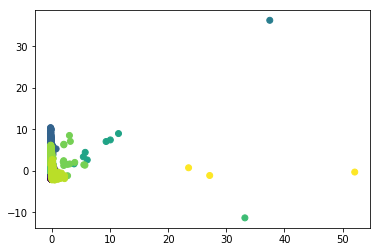

In [632]:

plt.scatter(newresults[:,0],newresults[:,1],c=labels)
# plt.xlim(0,10)
# plt.ylim(-10,10)

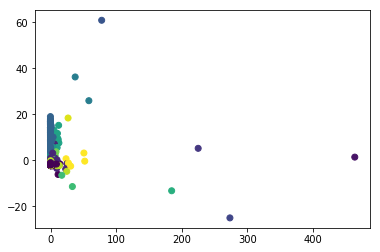

In [633]:
plt.scatter(results[:,0],results[:,1],c=cl.labels_)
# plt.xlim(-10,100)
# plt.ylim(-15,10)

In [634]:
#recluster after changes
cl = KMeans(35).fit(results)
newcl = KMeans(35).fit(newresults)

In [635]:
# %matplotlib widget
from mpl_toolkits.mplot3d import Axes3D

In [636]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(results[:,0],results[:,1],results[:,2],c=cl.labels_)

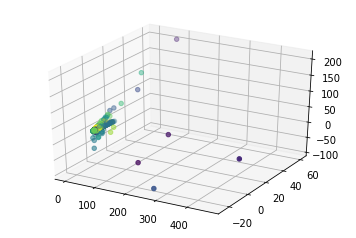

In [637]:

# plt.scatter(newresults[:,0],newresults[:,1],c=newcl.labels_)
# plt.xlim(-10,100)
# plt.ylim(-15,10)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(results[:,0],results[:,1],results[:,2],c=cl.labels_)

# ax.set_xlim3d(-10,10)
# ax.set_ylim3d(-15,10)
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(newresults[:,0],newresults[:,1],newresults[:,2],c=newcl.labels_)

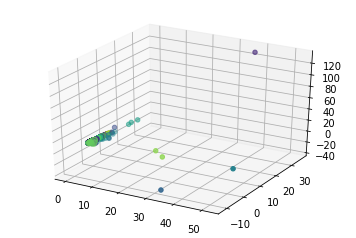

In [638]:
# %matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(newresults[:,0],newresults[:,1],newresults[:,2],c=newcl.labels_)
# ax.set_xlim3d(-1,1)
# ax.set_ylim3d(-3,3)
# ax.view_init(elev=-0, azim=90)
# for ii in range(10,360,10):
#     ax.view_init(elev=10, azim=ii)
#     fig.savefig("movie/movie{}.png".format(ii))

In [639]:
c = cl.cluster_centers_
#transform back to real numbers
centroids = scale.inverse_transform(pca.inverse_transform(c))
df_summary = pd.DataFrame(centroids, columns = data.columns)

In [640]:
cluster_sizes = pd.Series(cl.labels_).value_counts()
df_summary['cluster_size'] = cluster_sizes


In [641]:
df_summary.sort_values('cluster_size', ascending=False, axis=0, inplace=True)
df_summary

,outgoing_txns,incoming_txns,total_eth_sent,avg_eth_sent,total_usd_sent,avg_usd_sent,total_eth_recd,avg_eth_recd,total_usd_recd,avg_usd_recd,...,monthly_usd_recd,contracts_created,contract_txns_sent,incoming_avg_time_btwn_txns,incoming_std_time_btwn_txns,outgoing_avg_time_btwn_txns,outgoing_std_time_btwn_txns,num_tokens_used,eth_balance,cluster_size
28,33.935664,55.693345,1.866285e+02,5.717742e+00,1.138573e+05,3.854977e+03,1.915587e+02,5.066019,1.180043e+05,3.339116e+03,...,1.019675e+04,1.032457e-01,8.389098e+00,6.560906e+05,8.215366e+05,8.242989e+05,9.657083e+05,7.774824,7.510468,10382
25,38.373199,54.650968,3.418677e+02,1.387607e+01,1.362979e+05,4.957218e+03,4.082580e+02,15.630698,1.411235e+05,4.465508e+03,...,8.057509e+03,1.835786e-01,1.768257e+01,1.070920e+06,1.655102e+06,1.310933e+06,1.899909e+06,14.672657,20.852623,6456
22,42.470618,33.871852,2.410952e+02,1.011371e+01,8.917154e+04,4.147904e+03,2.336657e+02,8.886813,9.361910e+04,3.793265e+03,...,1.445513e+04,1.826281e-01,1.762241e+01,7.788149e+05,9.213220e+05,8.260544e+05,8.857161e+05,4.085832,13.460767,5838
11,6.291176,35.178413,3.464742e+01,5.271069e+00,1.911800e+04,2.938033e+03,4.904182e+01,4.467472,2.772115e+04,2.484486e+03,...,2.402355e+03,4.576173e-02,1.587179e+00,1.191024e+06,1.435909e+06,3.201052e+06,3.424217e+06,6.681599,8.040346,5182
31,16.522088,7.027610,4.670899e+01,4.251406e+00,2.568226e+04,2.306745e+03,4.961718e+01,7.019791,2.409785e+04,3.401319e+03,...,2.018814e+03,1.332831e-01,1.997139e+01,3.166161e+06,4.085061e+06,1.288186e+06,1.655544e+06,8.807731,7.359111,3975
20,7.053321,7.821017,5.892848e+01,7.011152e+00,2.654061e+04,3.273344e+03,8.181127e+01,9.773370,2.830640e+04,3.516896e+03,...,1.839444e+03,7.577175e-02,9.250390e+00,3.609637e+06,4.750876e+06,3.699006e+06,4.657325e+06,10.546305,14.410970,3209
27,4.617553,28.054255,5.312826e+01,1.010465e+01,2.213156e+04,4.408978e+03,1.069675e+02,10.275179,2.817564e+04,2.795165e+03,...,1.880922e+03,4.627660e-02,2.498191e+01,1.616222e+06,2.169235e+06,6.571410e+06,8.010156e+06,9.453723,25.105754,1882
0,127.935627,67.945061,9.680442e+02,1.058547e+01,5.491474e+05,5.707021e+03,1.056974e+03,10.914575,5.800580e+05,5.558395e+03,...,3.881507e+04,3.423973e-01,1.481853e+01,1.118490e+06,1.571866e+06,9.308612e+05,1.412361e+06,58.257492,18.516108,1803
30,9.921875,4.700521,1.236266e+02,8.739657e+00,4.228404e+04,3.278903e+03,1.235738e+02,22.311266,2.552654e+04,5.267887e+03,...,1.602685e+03,1.875000e-01,2.112500e+01,7.515851e+06,9.717300e+06,1.769197e+06,2.300939e+06,10.532986,25.626887,1152
5,4.768116,5.346711,8.868265e+01,1.468303e+01,1.631634e+04,3.154130e+03,1.190083e+02,18.158054,1.794009e+04,3.298697e+03,...,1.055663e+03,1.739130e-01,2.061315e+00,6.798435e+06,8.687376e+06,7.210108e+06,8.764361e+06,8.996656,18.728641,897


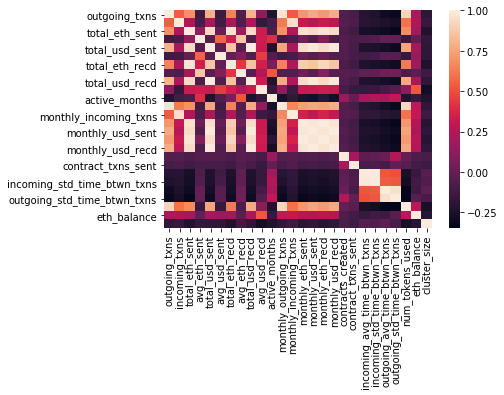

In [642]:
import seaborn as sns
sns.heatmap(df_summary.corr())

In [643]:
arr = df_summary.values

In [644]:
arr.shape

(35, 26)

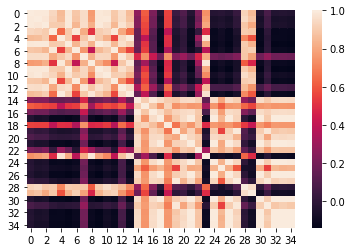

In [645]:
sns.heatmap(np.corrcoef(arr, rowvar=True))

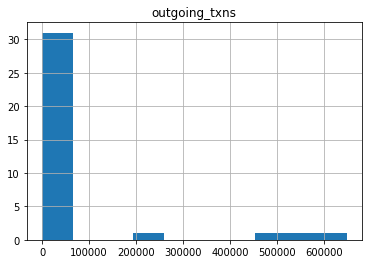

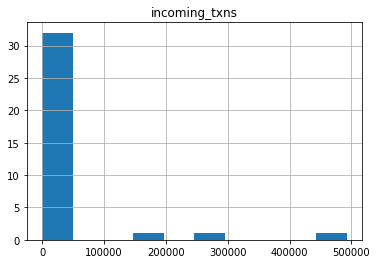

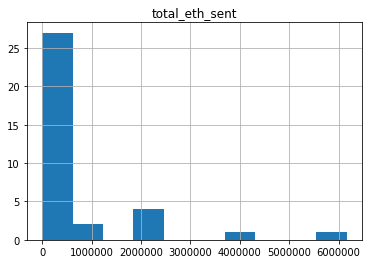

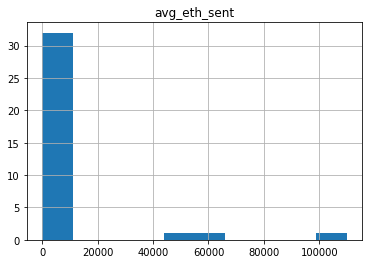

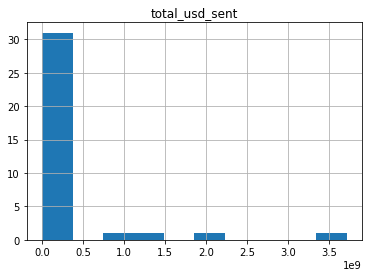

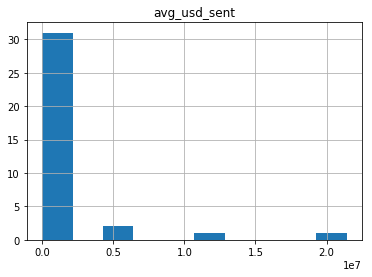

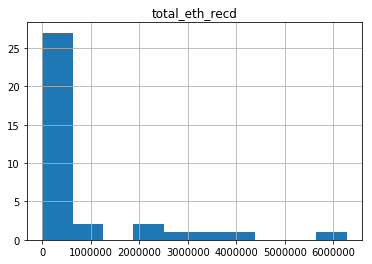

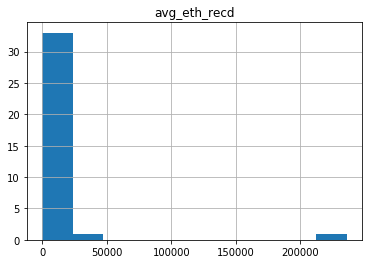

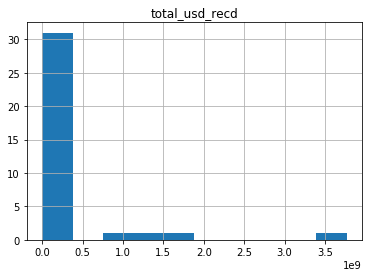

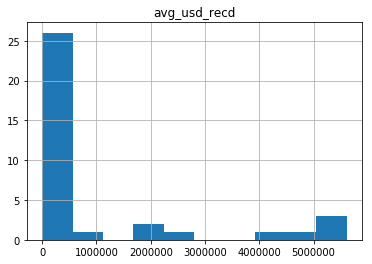

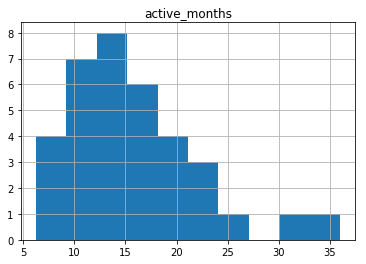

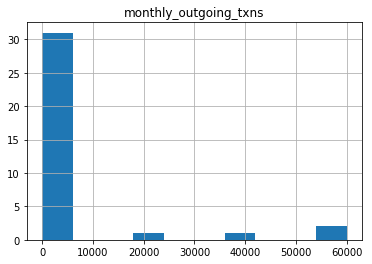

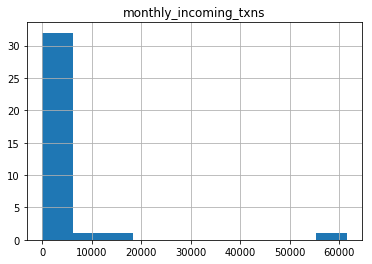

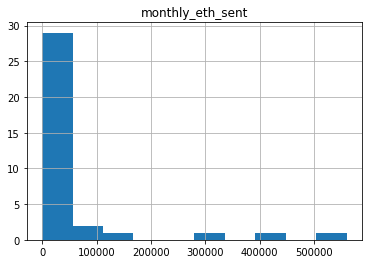

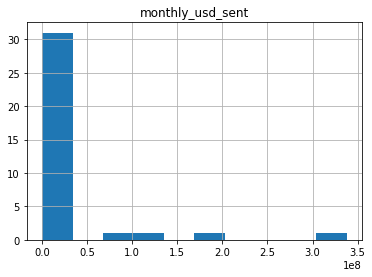

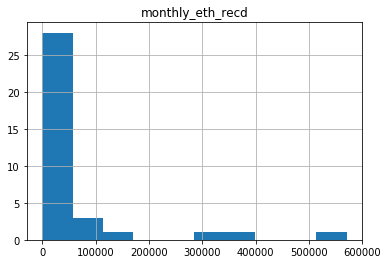

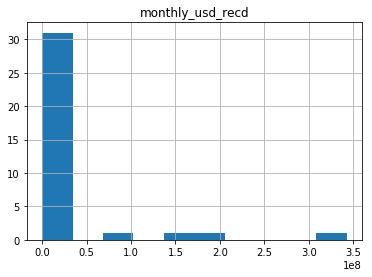

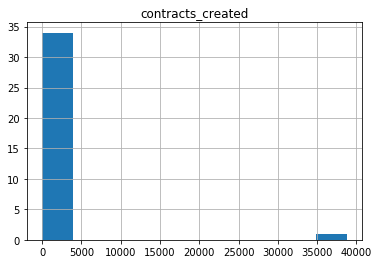

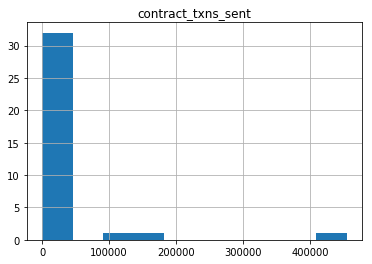

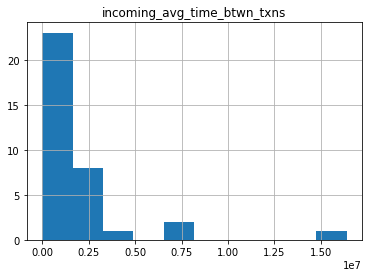

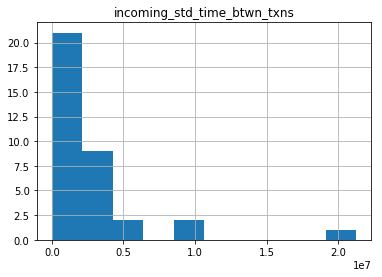

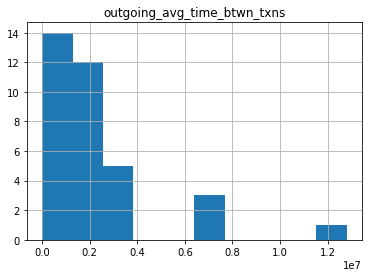

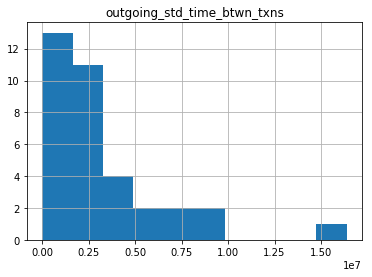

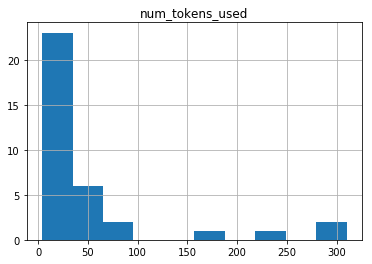

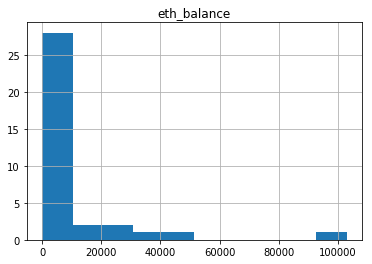

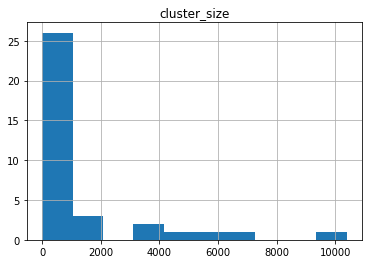

In [646]:
for col in df_summary.columns:
    df_summary[col].hist()
    plt.title(col)
    plt.show()

In [647]:
p = PCA(n_components=3)

In [648]:
vectors = p.fit_transform(arr[:8,:])

In [649]:

xs = vectors[:,0]
ys = vectors[:,1]
zs = vectors[:,2]

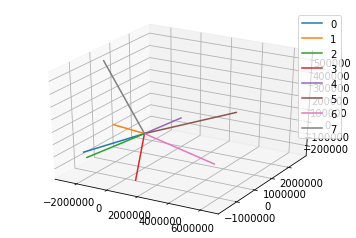

In [650]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i,(x,y,z) in enumerate(zip(xs,ys,zs)):
    ax.plot([0,x], [0,y],[0,z], label=i)
plt.legend()